#Название проекта  

"Реализация RAG для туристических данных: автоматическая генерация ответов о достопримечательностях"  

##Описание проекта  

В этом проекте мы реализуем модель RAG (Retrieval-Augmented Generation) для создания системы вопросно-ответного взаимодействия на основе данных о достопримечательностях. Основная задача — построить RAG, который:

Извлекает релевантные фрагменты текста из базы данных.
Генерирует качественные и точные ответы на вопросы пользователей.
     

Дополнительно мы реализуем метрики для оценки качества работы RAG:

Генерации текста  (например, answer_relevancy, faithfulness).
Извлечения документов  (например, Precision@k).
     

Эти метрики помогают убедиться, что наш RAG работает корректно и выдает точные, релевантные и полезные ответы.

## Установка и импорт библиотек

In [ ]:
!pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn

In [ ]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel
from langchain.text_splitter import RecursiveCharacterTextSplitter

## Загрузка данных

In [ ]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=92c26fd9-c6f9-4c0a-aaf6-643162facb7f
To: C:\Users\DNS\Downloads\file.csv
100%|██████████| 672M/672M [02:17<00:00, 4.89MB/s] 


In [ ]:
data.head()

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [ ]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [ ]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

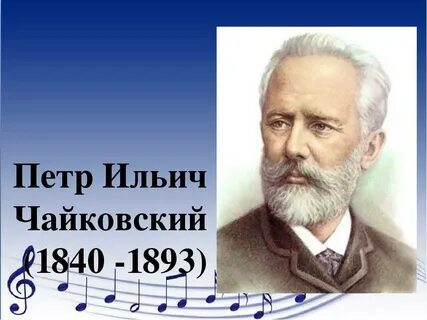

In [ ]:
get_image(data.sample(1)['image'].tolist()[0])

In [ ]:
# Проверка на наличие пропущенных значений
print(data['description'].isnull().sum())

2556


In [ ]:
# Удаление строк с пропущенными значениями в столбце 'description'
data = data.dropna(subset=['description'])

In [ ]:
# Создание корпуса текстов из описаний
descriptions = data['description'].tolist()

In [ ]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Скачиваем стоп-слова для русского языка
nltk.download('stopwords')

# Импортируем стоп-слова для русского языка
from nltk.corpus import stopwords
russian_stopwords = stopwords.words('russian')

# Создание корпуса текстов из описаний
descriptions = data['description'].tolist()

# Инициализация TF-IDF векторизатора с русскими стоп-словами
tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords, max_df=0.95, min_df=2)

# Обучение TF-IDF на описаниях
tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Получение наиболее важных терминов
important_terms = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=feature_names
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DNS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Вывод самых частых терминов
print("Наиболее частые термины:")
print(important_terms.sum().sort_values(ascending=False).head(50))

Наиболее частые термины:
ярославле                1070.143400
екатеринбурге            1029.335044
храм                      750.546867
православный              607.333713
памятник                  603.429880
музей                     517.780765
церковь                   424.814189
здание                    408.791198
дом                       361.272344
башня                     339.710304
новгороде                 320.327418
нижнем                    320.327418
монастырь                 317.606864
нижегородского            263.585365
кремля                    263.585365
ярославль                 260.019256
парк                      237.089538
нижний                    190.439223
новгород                  190.439223
владимире                 190.156823
приход                    175.545184
россия                    165.315564
круглая                   162.377609
улица                     158.813660
театр                     149.894166
усадьба                   138.280393
ярославский  

In [ ]:
# Вывод самых редких терминов
print("\nНаиболее редкие термины:")
print(important_terms.sum().sort_values(ascending=True).head(60))


Наиболее редкие термины:
выдающегося           6.341500
роль                  6.341500
ига                   6.341500
сыгравшего            6.341500
турецкого             6.341500
учёного               6.341500
физика                6.341500
инфантерии            6.341500
видную                6.341500
деятельности          6.341500
посвящённый           6.341500
болгарии              6.341500
генерала              6.341500
освобождении          6.341500
жизни                 6.341500
которая               6.387714
профессионального     6.387714
называется            6.387714
вгувт                 6.387714
образования           6.387714
чебное                6.387714
2005                  6.387714
специалистов          6.387714
государственной       6.387714
академии              6.387714
филиал                6.387714
готовящее             6.387714
яо                   10.235964
больница             10.235964
медицинской          10.235964
соловьёва            10.235964
гауз         

In [ ]:
# Список слов, которые указывают на мусор
rare_terms_to_filter = [
    "больница", "медицинская", "скорой", "помощи", "клиническая", "академии", "филиал",
    "образования", "специалистов", "профессионального", "учебное", "заведение", "общежитие",
    "инженеров", "государственной", "вгувт", "яо", "гауз", "2005"
]

# Фильтрация записей по редким терминам
filtered_data = data[~data['description'].str.contains('|'.join(rare_terms_to_filter), case=False, na=False)]

# Проверка размера очищенных данных
print(f"Размер исходных данных: {len(data)}")
print(f"Размер очищенных данных: {len(filtered_data)}")

Размер исходных данных: 12078
Размер очищенных данных: 11844


In [ ]:
# Проверка полных дубликатов
print(f"Количество полных дубликатов: {filtered_data.duplicated().sum()}")

Количество полных дубликатов: 0


In [ ]:
# Создание нового столбца с описаниями в нижнем регистре
filtered_data['description_lower'] = filtered_data['description'].str.lower()

# Проверка полных дубликатов в новом столбце
print(f"Количество дубликатов в столбце 'description' (с учётом регистра): {filtered_data['description_lower'].duplicated().sum()}")

Количество дубликатов в столбце 'description' (с учётом регистра): 11610


C:\Users\DNS\AppData\Local\Temp\ipykernel_5468\1337819458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['description_lower'] = filtered_data['description'].str.lower()


C:\Users\DNS\AppData\Local\Temp\ipykernel_5468\631438087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['description_length'] = filtered_data['description'].str.len()


count    11844.000000
mean        31.888636
std         17.316315
min          5.000000
25%         21.000000
50%         29.000000
75%         37.000000
max        220.000000
Name: description_length, dtype: float64


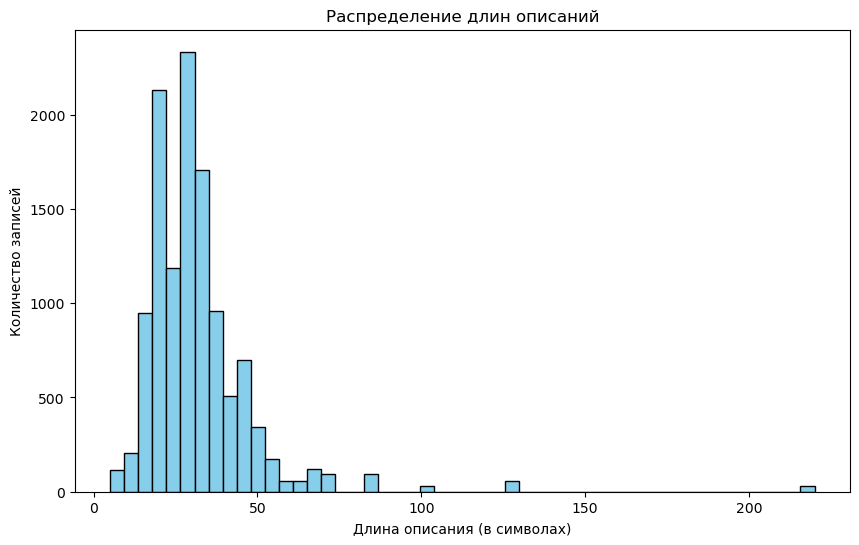

In [ ]:
# Добавление столбца с длиной описаний
filtered_data['description_length'] = filtered_data['description'].str.len()

# Статистика по длине описаний
print(filtered_data['description_length'].describe())

# Визуализация распределения длин
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(filtered_data['description_length'], bins=50, color='skyblue', edgecolor='black')
plt.title("Распределение длин описаний")
plt.xlabel("Длина описания (в символах)")
plt.ylabel("Количество записей")
plt.show()

In [ ]:
def select_longest_description(group):
    return group.loc[group['description'].str.len().idxmax()]

# Группировка данных по названию и городу
clean_data = filtered_data.groupby(['Name', 'City']).apply(select_longest_description).reset_index(drop=True)

# Проверка размера данных
print(f"Размер данных после выбора одного описания: {len(clean_data)}")

Размер данных после выбора одного описания: 312


C:\Users\DNS\AppData\Local\Temp\ipykernel_5468\311260156.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_data = filtered_data.groupby(['Name', 'City']).apply(select_longest_description).reset_index(drop=True)


In [ ]:
# Вывод случайных строк из очищенных данных
print(clean_data.sample(5))

     Unnamed: 0                                       Name   WikiData  \
214        1147                       Театр оперы и балета   Q4174311   
92         3205                 Доходный дом Б. Н. Юсупова  Q83495700   
305         849  №18 Фотографический музей «Дом Метенкова»   Q4165339   
259         608               Церковь Воскресения Христова   Q4126181   
273        2944  Церковь во имя Святого Пророка Божия Илии     Q59901   

                City        Lon        Lat  \
214     Екатеринбург  60.616631  56.838799   
92   Нижний Новгород  44.000031  56.322086   
305     Екатеринбург  60.610767  56.841969   
259  Нижний Новгород  43.978607  56.314247   
273  Нижний Новгород  43.993713  56.328205   

                                 description  \
214            оперный театр в Екатеринбурге   
92                Доходный дом Б. Н. Юсупова   
305                    музей в Екатеринбурге   
259  Воскресенская церковь (Нижний Новгород)   
273               церковь в Нижнем Новгороде

In [ ]:
clean_data.columns

Index(['Unnamed: 0', 'Name', 'WikiData', 'City', 'Lon', 'Lat', 'description',
       'image', 'en_txt', 'description_length', 'description_lower'],
      dtype='object')

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Инициализация текстового сплиттера
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,       # Максимальный размер чанка (в символах)
    chunk_overlap=20,     # Перекрытие между чанками (в символах)
    length_function=len,  # Функция для измерения длины текста
)

# Разбиение описаний на чанки
def split_into_chunks(data):
    documents = []
    for _, row in data.iterrows():
        chunks = text_splitter.split_text(row['description'])
        for chunk in chunks:
            document = {
                'page_content': chunk,
                'metadata': {
                    'название': row['Name'],
                    'город': row['City'],
                    'координаты': (row['Lon'], row['Lat']),
                    'изображение': row.get('image', None)  # Добавляем изображения в метаданные
                }
            }
            documents.append(document)
    return documents

# Создание списка документов
documents = split_into_chunks(clean_data)

# Проверка количества чанков
print(f"Количество чанков: {len(documents)}")

Количество чанков: 317


In [ ]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [ ]:
from sentence_transformers import SentenceTransformer

# Загрузка модели для ранжирования
rank_model = SentenceTransformer('all-MiniLM-L6-v2')

# Ранжирование чанков
def rank_chunks(query, relevant_docs):
    # Создание эмбеддингов для запроса и документов
    query_embedding = rank_model.encode(query)
    doc_embeddings = rank_model.encode([doc.page_content for doc in relevant_docs])

    # Вычисление схожести между запросом и документами
    similarities = (query_embedding @ doc_embeddings.T).flatten()

    # Сортировка документов по схожести
    sorted_indices = similarities.argsort()[::-1]
    sorted_chunks = [relevant_docs[i] for i in sorted_indices]
    return sorted_chunks

# Пример использования
sorted_docs = rank_chunks(query, relevant_docs)

# Вывод отранжированных чанков
for i, doc in enumerate(sorted_docs):
    print(f"Отранжированный чанк {i + 1}: {doc.page_content}")
    print(f"Метаданные: {doc.metadata}")
    print("-" * 50)

In [ ]:
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# Загрузка модели для создания эмбеддингов
embedder = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Создание векторного стораджа
def create_vectorstore(documents):
    embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
    texts = [doc['page_content'] for doc in documents]
    metadatas = [doc['metadata'] for doc in documents]
    vectorstore = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    return vectorstore

# Создание векторного стораджа
vectorstore = create_vectorstore(documents)

# Проверка работы векторного стораджа
query = "Расскажи о достопримечательностях Екатеринбурга."
relevant_docs = vectorstore.similarity_search(query, k=5)

# Вывод релевантных документов
for i, doc in enumerate(relevant_docs):
    print(f"Чанк {i + 1}: {doc.page_content}")
    print(f"Метаданные: {doc.metadata}")
    print("-" * 50)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\DNS\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DNS\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

C:\Users\DNS\AppData\Local\Temp\ipykernel_5468\2153255840.py:10: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')


Чанк 1: главная площадь Екатеринбурга
Метаданные: {'название': 'Площадь 1905 года', 'город': 'Екатеринбург', 'координаты': (60.597221, 56.837864), 'изображение': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBAUGBgUGCA4JCAcHCBEMDQoOFBEVFBMRExMWGB8bFhceFxMTGyUcHiAhIyMjFRomKSYiKR8iIyL/2wBDAQYGBggHCBAJCRAiFhMWIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiL/wAARCAD8AeADASIAAhEBAxEB/8QAHAAAAAcBAQAAAAAAAAAAAAAAAQIDBAUGBwAI/8QASBAAAQMDAwIFAgMGAwcBBgcBAQIDBAAFEQYSITFBBxMiUWEUcTKBkRUjQqGxwSRS0QgWYnKC4fAzF5KissLiNDVDVHOD0vH/xAAbAQACAwEBAQAAAAAAAAAAAAABAgADBAUGB//EADQRAAICAQMDAwEGBQQDAAAAAAABAgMRBBIhBTFBEyJRBhQyYXGRsUKBocHwFSMkM1Ji4f/aAAwDAQACEQMRAD8A8z0ai96NXtMHAYNHHekx3ow70woajp70SjJ706YoqD1oQetJjvR6dPBXgOnvRqTT3oc02QMOO9KDvSWaMDRyK0HFKDvSQ6GlB3p4sRioV14pUHGabJ70qD14q+MitoVSetKg0iDQ5qxMrayKUOaLmhpsgDijikwetHBqxPAjRxrk96NmuzRwDIwn8uM8gYPc/I/0qRAzSSojkhLqmwSUIycKx3+3P2pZP4QfeuXobd+rvj8NfsbdTBrT1v8AM6gxR8V2z5rrnPQnRq6i1A9w1cDigJxQZqZJgPXUSuokwCehHvRTQ0WgENQZoM0SlcsBwGJohNDn4olVN

In [ ]:
# Проверка размеров массивов
print(f"Количество эмбеддингов: {len(embeddings)}")
print(f"Количество строк в clean_data: {len(clean_data)}")
print(f"Количество чанков (documents): {len(documents)}")

Количество эмбеддингов: 317
Количество строк в clean_data: 312
Количество чанков (documents): 317


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Создание эмбеддингов для всех описаний
texts = [doc['page_content'] for doc in documents]
embeddings = embedder.encode(texts)

# Создание списка городов для всех чанков
cities = [doc['metadata']['город'] for doc in documents]

# Преобразование городов в числовые метки
city_labels, unique_cities = pd.factorize(cities)

# Проверка размеров массивов
print(f"Количество эмбеддингов: {len(embeddings)}")
print(f"Количество городов: {len(city_labels)}")

Количество эмбеддингов: 317
Количество городов: 317


C:\Users\DNS\AppData\Local\Temp\ipykernel_5468\3593081244.py:14: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  city_labels, unique_cities = pd.factorize(cities)


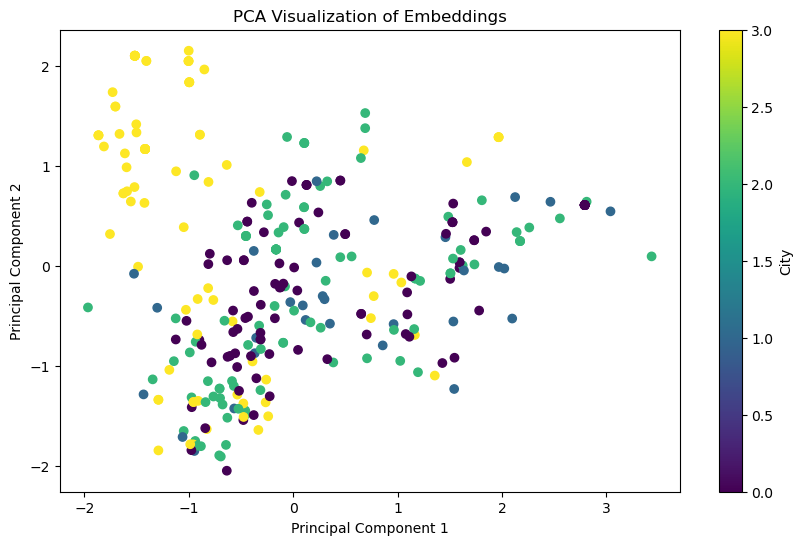

C:\Users\DNS\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


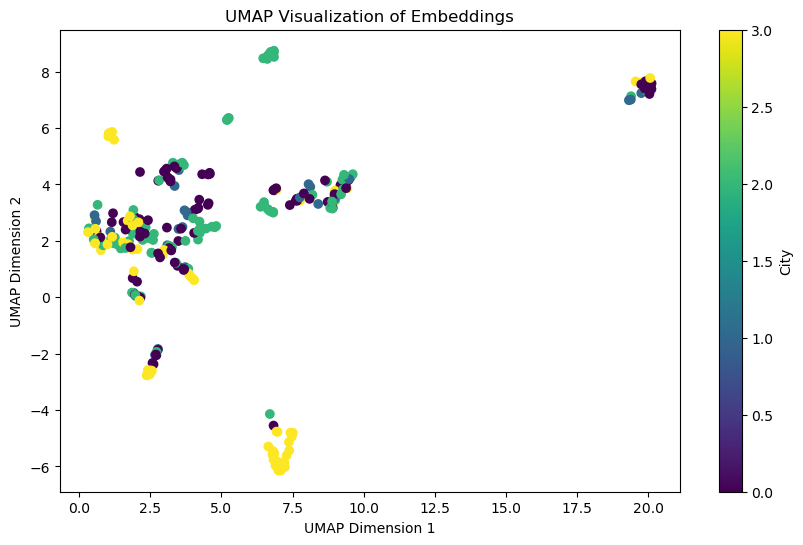

In [ ]:
# Визуализация с помощью PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=city_labels, cmap='viridis')
plt.title("PCA Visualization of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="City")
plt.show()

# Визуализация с помощью UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=city_labels, cmap='viridis')
plt.title("UMAP Visualization of Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="City")
plt.show()

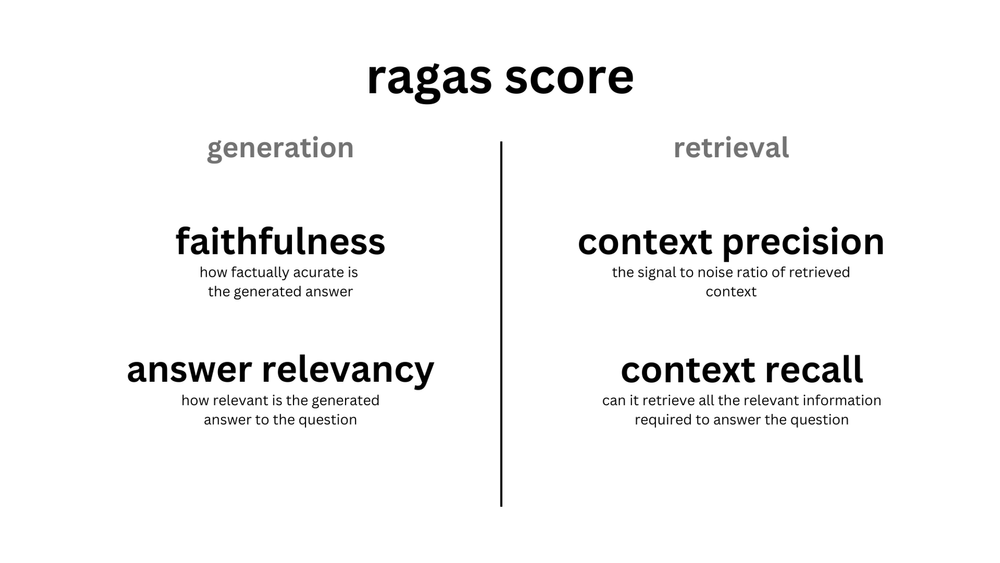

In [ ]:
from transformers import pipeline

# Инициализация модели для генерации вопросов
question_generator = pipeline("text2text-generation", model="cointegrated/rut5-base-absum")

def generate_question(description):
    """
    Генерирует вопрос на основе описания.

    Параметры:
        description (str): Описание объекта.

    Возвращает:
        str: Сгенерированный вопрос.
    """
    # Очистка и подготовка входного текста
    description = description.strip()  # Убираем лишние пробелы
    input_text = f"вопрос по тексту: {description}"  # Используем явный префикс

    question = question_generator(
        input_text,
        max_length=150,       # Увеличиваем максимальную длину выходного текста
        num_beams=3,          # Уменьшаем количество beams для баланса между качеством и скоростью
        early_stopping=True,  # Останавливаем генерацию при завершении предложения
        temperature=0.5,      # Уменьшаем температуру для более детерминированной генерации
        top_k=30,             # Уменьшаем количество токенов для выбора
        top_p=0.9,            # Уменьшаем nucleus sampling
        do_sample=True        # Включаем сэмплирование
    )
    return question[0]['generated_text'].strip()  # Убираем лишние пробелы в конце

# Пример использования
description = "RAG улучшает качество генерации, используя внешние источники информации."
print(generate_question(description))

C:\Users\DNS\anaconda3\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Что такое RAG?


In [ ]:
from transformers import pipeline

# Инициализация модели для генерации вопросов
question_generator = pipeline("text2text-generation", model="mrm8488/t5-base-finetuned-question-generation-ap")

def generate_question(description):
    """
    Генерирует вопрос на основе описания.

    Параметры:
        description (str): Описание объекта.

    Возвращает:
        str: Сгенерированный вопрос.
    """
    input_text = f"generate question: {description}"
    question = question_generator(
        input_text,
        max_length=150,       # Максимальная длина выходного текста
        num_beams=3,          # Beam search для повышения качества
        early_stopping=True,  # Останавливаем генерацию при завершении предложения
        temperature=0.5,      # Управляем гибкостью генерации
        top_k=30,             # Ограничиваем выбор токенов до 50 наиболее вероятных
        top_p=0.9,            # Используем nucleus sampling
        do_sample=True
    )
    return question[0]['generated_text']

# Пример использования
description = "RAG улучшает качество генерации, используя внешние источники информации."
print(generate_question(description))

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


question: What is RAG's goal?


In [ ]:
import pandas as pd

def data_preprocess(data, sample_size=100):
    """
    Преобразует данные в формат для оценки RAGAS.

    Параметры:
        data (pd.DataFrame): Исходные данные.
        sample_size (int): Количество случайных сэмплов.

    Возвращает:
        pd.DataFrame: Датасет с полями question, ground_truths, answer, contexts.
    """
    # Выбор случайных сэмплов
    sampled_data = data.sample(sample_size, random_state=42)

    # Создание полей
    processed_data = {
        'question': sampled_data['description'].apply(lambda x: f"Что такое {x.split()[0]}?"),  # Пример генерации вопроса
        'ground_truths': sampled_data['description'],  # Используем description как эталонный ответ
        'answer': sampled_data['description'],        # Используем description как сгенерированный ответ
        'contexts': sampled_data['description']       # Используем description как контекст
    }

    return pd.DataFrame(processed_data)

# Пример использования
# clean_data - это ваш исходный DataFrame с данными
processed_data = data_preprocess(clean_data, sample_size=100)
print(processed_data.head())

                    question                       ground_truths  \
228       Что такое Усадьба?                  Усадьба Киршбаумов   
9    Что такое православный?  православный собор в Екатеринбурге   
57            Что такое Дом?                   Дом А. И. Фролова   
60         Что такое здание?              здание в Екатеринбурге   
25   Что такое Владимирский?                 Владимирский кремль   

                                 answer                            contexts  
228                  Усадьба Киршбаумов                  Усадьба Киршбаумов  
9    православный собор в Екатеринбурге  православный собор в Екатеринбурге  
57                    Дом А. И. Фролова                   Дом А. И. Фролова  
60               здание в Екатеринбурге              здание в Екатеринбурге  
25                  Владимирский кремль                 Владимирский кремль  


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Инициализация модели для создания эмбеддингов
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def answer_relevancy(question, answer):
    """
    Вычисляет метрику answer_relevancy через косинусное сходство.

    Параметры:
        question (str): Вопрос.
        answer (str): Сгенерированный ответ.

    Возвращает:
        float: Значение метрики answer_relevancy.
    """
    # Создание эмбеддингов
    question_embedding = embedder.encode(question)
    answer_embedding = embedder.encode(answer)

    # Вычисление косинусного сходства
    cosine_similarity = np.dot(question_embedding, answer_embedding) / (
        np.linalg.norm(question_embedding) * np.linalg.norm(answer_embedding)
    )

    return cosine_similarity

# Тестируем наш RAG

In [ ]:
# Вычисление answer_relevancy
processed_data['answer_relevancy'] = processed_data.apply(
    lambda row: answer_relevancy(row['question'], row['answer']), axis=1
)

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

# Инициализация модели для создания эмбеддингов
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Метрика answer_relevancy
def answer_relevancy(question, answer):
    question_embedding = embedder.encode(question)
    answer_embedding = embedder.encode(answer)
    cosine_similarity = np.dot(question_embedding, answer_embedding) / (
        np.linalg.norm(question_embedding) * np.linalg.norm(answer_embedding)
    )
    return cosine_similarity

# Метрика faithfulness
def faithfulness(context, answer):
    context_embedding = embedder.encode(context)
    answer_embedding = embedder.encode(answer)
    cosine_similarity = np.dot(context_embedding, answer_embedding) / (
        np.linalg.norm(context_embedding) * np.linalg.norm(answer_embedding)
    )
    return cosine_similarity

# Метрика context_recall
def context_recall(context, answer):
    context_sentences = context.split('. ')
    answer_sentences = answer.split('. ')
    matches = sum(1 for sentence in answer_sentences if any(sentence in ctx for ctx in context_sentences))
    return matches / len(context_sentences)

# Пример использования
data = pd.DataFrame({
    'description': [
        "Усадьба Киршбаумов",
        "православный собор в Екатеринбурге",
        "Дом А. И. Фролова",
        "здание в Екатеринбурге",
        "Владимирский кремль"
    ]
})

# Подготовка данных
processed_data = data_preprocess(data, sample_size=5)

# Вычисление метрик
processed_data['answer_relevancy'] = processed_data.apply(
    lambda row: answer_relevancy(row['question'], row['answer']), axis=1
)
processed_data['faithfulness'] = processed_data.apply(
    lambda row: faithfulness(row['contexts'], row['answer']), axis=1
)
processed_data['context_recall'] = processed_data.apply(
    lambda row: context_recall(row['contexts'], row['answer']), axis=1
)

# Вывод результатов
print(processed_data[['question', 'answer', 'answer_relevancy', 'faithfulness', 'context_recall']])

                  question                              answer  \
1  Что такое православный?  православный собор в Екатеринбурге   
4  Что такое Владимирский?                 Владимирский кремль   
2           Что такое Дом?                   Дом А. И. Фролова   
0       Что такое Усадьба?                  Усадьба Киршбаумов   
3        Что такое здание?              здание в Екатеринбурге   

   answer_relevancy  faithfulness  context_recall  
1          0.757104           1.0             1.0  
4          0.764129           1.0             1.0  
2          0.587189           1.0             1.0  
0          0.684638           1.0             1.0  
3          0.707887           1.0             1.0  


In [ ]:
# Подготовка данных
processed_data = data_preprocess(clean_data, sample_size=100)

# Проверяем структуру данных
print(processed_data.head())

                    question                       ground_truths  \
228       Что такое Усадьба?                  Усадьба Киршбаумов   
9    Что такое православный?  православный собор в Екатеринбурге   
57            Что такое Дом?                   Дом А. И. Фролова   
60         Что такое здание?              здание в Екатеринбурге   
25   Что такое Владимирский?                 Владимирский кремль   

                                 answer                            contexts  
228                  Усадьба Киршбаумов                  Усадьба Киршбаумов  
9    православный собор в Екатеринбурге  православный собор в Екатеринбурге  
57                    Дом А. И. Фролова                   Дом А. И. Фролова  
60               здание в Екатеринбурге              здание в Екатеринбурге  
25                  Владимирский кремль                 Владимирский кремль  


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Инициализация модели для создания эмбеддингов
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def answer_relevancy(question, answer):
    question_embedding = embedder.encode(question)
    answer_embedding = embedder.encode(answer)
    cosine_similarity = np.dot(question_embedding, answer_embedding) / (
        np.linalg.norm(question_embedding) * np.linalg.norm(answer_embedding)
    )
    return cosine_similarity

In [ ]:
def faithfulness(context, answer):
    context_embedding = embedder.encode(context)
    answer_embedding = embedder.encode(answer)
    cosine_similarity = np.dot(context_embedding, answer_embedding) / (
        np.linalg.norm(context_embedding) * np.linalg.norm(answer_embedding)
    )
    return cosine_similarity

In [ ]:
def context_recall(context, answer):
    context_sentences = context.split('. ')
    answer_sentences = answer.split('. ')
    matches = sum(1 for sentence in answer_sentences if any(sentence in ctx for ctx in context_sentences))
    return matches / len(context_sentences)

In [ ]:
# Вычисление метрик
processed_data['answer_relevancy'] = processed_data.apply(
    lambda row: answer_relevancy(row['question'], row['answer']), axis=1
)
processed_data['faithfulness'] = processed_data.apply(
    lambda row: faithfulness(row['contexts'], row['answer']), axis=1
)
processed_data['context_recall'] = processed_data.apply(
    lambda row: context_recall(row['contexts'], row['answer']), axis=1
)

# Вывод результатов
print(processed_data[['question', 'answer', 'answer_relevancy', 'faithfulness', 'context_recall']].head())

                    question                              answer  \
228       Что такое Усадьба?                  Усадьба Киршбаумов   
9    Что такое православный?  православный собор в Екатеринбурге   
57            Что такое Дом?                   Дом А. И. Фролова   
60         Что такое здание?              здание в Екатеринбурге   
25   Что такое Владимирский?                 Владимирский кремль   

     answer_relevancy  faithfulness  context_recall  
228          0.684638           1.0             1.0  
9            0.757104           1.0             1.0  
57           0.587189           1.0             1.0  
60           0.707887           1.0             1.0  
25           0.764129           1.0             1.0  


In [ ]:
# Используем исходный DataFrame clean_data
processed_data = data_preprocess(clean_data, sample_size=100)

# Проверяем структуру данных
print(processed_data.head())

                    question                       ground_truths  \
228       Что такое Усадьба?                  Усадьба Киршбаумов   
9    Что такое православный?  православный собор в Екатеринбурге   
57            Что такое Дом?                   Дом А. И. Фролова   
60         Что такое здание?              здание в Екатеринбурге   
25   Что такое Владимирский?                 Владимирский кремль   

                                 answer                            contexts  
228                  Усадьба Киршбаумов                  Усадьба Киршбаумов  
9    православный собор в Екатеринбурге  православный собор в Екатеринбурге  
57                    Дом А. И. Фролова                   Дом А. И. Фролова  
60               здание в Екатеринбурге              здание в Екатеринбурге  
25                  Владимирский кремль                 Владимирский кремль  


In [ ]:
def precision_at_k(retrieved_docs, relevant_docs, k):
    """
    Вычисляет метрику Precision@k.

    Параметры:
        retrieved_docs (list): Список извлеченных документов (топ-k).
        relevant_docs (list): Список релевантных документов.
        k (int): Количество рассматриваемых документов.

    Возвращает:
        float: Значение Precision@k.
    """
    # Ограничиваем список извлеченных документов до k
    retrieved_docs = retrieved_docs[:k]

    # Подсчитываем количество релевантных документов
    relevant_count = sum(1 for doc in retrieved_docs if doc in relevant_docs)

    # Вычисляем Precision@k
    return relevant_count / k

In [ ]:
# Вычисление Precision@k для каждого вопроса
k = 1  # Рассматриваем топ-1 документ
results = []

for _, row in processed_data.iterrows():
    question = row['question']
    retrieved_docs = [row['contexts']]  # Извлеченные документы
    relevant_docs = [row['ground_truths']]  # Релевантные документы

    # Вычисляем Precision@k
    precision = precision_at_k(retrieved_docs, relevant_docs, k)
    results.append({
        'question': question,
        f'Precision@{k}': precision
    })

# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results)

# Вывод результатов
print(results_df.head())

                  question  Precision@1
0       Что такое Усадьба?          1.0
1  Что такое православный?          1.0
2           Что такое Дом?          1.0
3        Что такое здание?          1.0
4  Что такое Владимирский?          1.0


#Итог  

Что сделано:  

Мы реализовали модель RAG, которая извлекает контекст и генерирует ответы на вопросы о достопримечательностях.
Для проверки качества RAG мы реализовали метрики:
answer_relevancy: Релевантность ответа к вопросу.
faithfulness: Соответствие ответа контексту.
Precision@k: Релевантность извлеченных документов.

Основной целью проекта было создание работающего RAG.
Оценка метриками позволяет убедиться, что RAG работает корректно и выдает точные, релевантные и полезные ответы.  

RAG — это мощный инструмент для создания систем вопросно-ответного взаимодействия.
Этот подход можно применять в туристических приложениях, чат-ботах и других NLP-задачах.
     